<a href="https://colab.research.google.com/github/UmenEO/AttestationUmen/blob/main/seminar2_sknn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
username = 'recspert'
repo = 'ITP-SeqRecSys-2024'

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{username}/{repo}.git

Cloning into 'ITP-SeqRecSys-2024'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 39 (delta 9), reused 30 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 382.16 KiB | 3.44 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-627emsqy/polara_3fa473042a8a4e5f8a101ab4d9af6640
  Running command git clone --filter=blob:none --quiet https://github.com/evfro/polara.git /tmp/pip-install-627emsqy/polara_3fa473042a8a4e5f8a101ab4d9af6640
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit 8e48cfd88e616ca53f8bbda1702a3e2c8abaf38e
  Preparing metadata (setup.py) ... done
  Created wheel for polara: filename=polara-0.7.2.dev0-py3-none-any.whl size=89446 sha256=2d3d9c7ce2ced74d556b270fb0c199fcdd5808cda03b14d64dda20bd185f9603
  Stored in directory: /tmp/pip-ephem-wheel-cache-o5r35xgq/wheels/3f/3a/1f/42058978e585b23c384652846b96b72870f3c8c12976cdac50
Successfully built polara


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix, coo_matrix, diags

from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex

%cd {repo}
from source.dataprep.dataprep import transform_indices, generate_interactions_matrix
from source.evaluation.evaluation import topn_recommendations, model_evaluate, downvote_seen_items, build_evaluate_model
from source.helpers.knn import truncate_similarity
from source.helpers.similarity import jaccard_similarity, weighted_jaccard_similarity
from source.helpers.plot import plot_histories
from source.models.basic import Random, Popular
%cd -

/content/ITP-SeqRecSys-2024
/content


In [ ]:
data = get_movielens_data(include_time=True)
data_description = {
    'users':'userid',
    'items':'movieid',
    'feedback':'rating',
    'timestamp':'timestamp'
}

In [ ]:
# define the timepoint corresponding to the 95% percentile
test_timepoint = data['timestamp'].quantile(
    q=0.95, interpolation='nearest'
)

# users with interaction after timepoint go to test
_test_data_ = data.query('timestamp >= @test_timepoint')
test_users = _test_data_[data_description['users']].unique()
test_data_ = data.query(
    'userid in @test_users'
)
# interaction before timepoint go to train,
# also hiding the interactions of test users
# this ensures the warm-start strategy
train_data_ = data.query(
    'userid not in @test_data_.userid.unique() and timestamp < @test_timepoint'
)

In [ ]:
# transform user and item ids for convenience, reindex test data
training, data_index = transform_indices(train_data_.copy(), data_description['users'], data_description['items'])

# reindex items in test set, if item was not in train, assign -1 as itemid
test_data = reindex(test_data_, data_index['items'], filter_invalid=False)

In [ ]:
test_data[test_data[data_description['items']] == -1]

,userid,movieid,rating,timestamp
16179,127,-1,3,1007224983
23716,169,-1,4,977208529
24559,173,-1,3,993227500
27736,195,-1,4,1015890867
27908,195,-1,4,1000996574
...,...,...,...,...
984215,5948,-1,5,1016563709
993604,6001,-1,3,964030592
993739,6001,-1,1,956807238
996637,6016,-1,3,995663888


In [ ]:
# the items that were not in the training set have itemid -1
# let's drop the items with itemid -1 and all consequtive interactions
test_data = test_data.sort_values(by=[data_description['users'], data_description['timestamp']])
mask = test_data.groupby(data_description['users']).cummin()[data_description['items']] == -1
test_data_truncated = test_data[~mask]

filtered = test_data_truncated[test_data_truncated[data_description['timestamp']] >= test_timepoint]
interaction_counts = filtered.groupby(data_description['users']).size()
test_users = interaction_counts[interaction_counts >= 2].index.tolist()

test_prepared = test_data_truncated[test_data_truncated[data_description['users']].isin(test_users)]

In [ ]:
# last interaction for test holdout
# second-to-last for validation holdout
testset_, holdout_ = leave_one_out(
    test_prepared, target='timestamp', sample_top=True, random_state=0
)
testset_valid_, holdout_valid_ = leave_one_out(
    testset_, target='timestamp', sample_top=True, random_state=0
)

# assert the users in testset are the same as in holdout
test_users = np.intersect1d(testset_valid_.userid.unique(), holdout_valid_.userid.unique())
testset_valid = testset_valid_.query('userid in @test_users').sort_values('userid')
holdout_valid = holdout_valid_.query('userid in @test_users').sort_values('userid')

# assert the users in testset_valid are the same as in holdout_valid
test_users_final = np.intersect1d(testset_valid_.userid.unique(), holdout_valid_.userid.unique())
testset = testset_.query('userid in @test_users_final').sort_values('userid')
holdout = holdout_.query('userid in @test_users_final').sort_values('userid')

In [ ]:
data_description = {
    'n_users':training.nunique()['userid'],
    'n_items':training.nunique()['movieid'],
    'users':'userid',
    'items':'movieid',
    'feedback':'rating',
    'timestamp':'timestamp'
}

## Association rules

$$
\text{score}_{AR}(u, i) = \text{PairCount}_{AR}(i_{|I_u|}, i)
$$

$$
\text{PairCount}_{AR}(i, j) = |U_i\cap U_j|
$$

$I_u$ - interaction history of user $u$, $U_i$ - set of users who interacted with item $i$, $i_{|I_u|}$ - last item of user $u$

In [ ]:
class AR:
    def __init__(self, model_config=None) -> None:
        pass

    def build(self, data, data_description):
        '''
        Builds association rules matrix.
        '''
        interactions = generate_interactions_matrix(data, data_description)

        similarity = interactions.T.dot(interactions)
        similarity.setdiag(0)
        similarity.eliminate_zeros()
        self.rules = similarity

    def recommend(self, data, data_description):
        '''
        Generate scores for given data.
        '''
        # Drop duplicates, keeping the last interaction for each user

        data_sorted = data.sort_values(by=[data_description['users'], data_description['timestamp']])
        data_last_interaction = data_sorted.drop_duplicates(subset=data_description['users'], keep='last')

        interactions = generate_interactions_matrix(data_last_interaction, data_description, rebase_users=True)

        scores = interactions.dot(self.rules).A
        return scores

In [ ]:
ar_model = AR()
ar_model.build(training, data_description)
ar_scores = ar_model.recommend(testset_valid, data_description)

In [ ]:
ar_scores

array([[112.,  65.,  51., ...,   1.,   1.,  11.],
       [461., 222., 117., ...,   3.,   5.,  37.],
       [ 38.,  33.,  19., ...,   0.,   0.,   2.],
       ...,
       [117.,  59.,  52., ...,   0.,   2.,  11.],
       [599., 245., 120., ...,   4.,   3.,  48.],
       [612., 195., 164., ...,   1.,   3.,  46.]])

## Sequential rules

$$
\text{score}_{SR}(u, i) = \sum_{j \in I_u  \backslash \{i\}} \textbf{1}[j=i_{|I_u|}]\text{PairCount}_{SR}(j \rightarrow i)
$$

$$
\text{PairCount}_{SR}(j \rightarrow i) = \sum_{v\in U} \textbf{1}[j\rightarrow_v i]
$$

where $j\rightarrow_u i$ means that item $i$ follows item $j$ in the interaction history of user $u$. $U$ is the set of users

In [ ]:
class SR:
    def __init__(self, model_config=None) -> None:
        pass

    def build(self, data, data_description):
        'Builds sequential rules of size two'
        rules = {}

        # get chronological interaction history for each user
        histories = (
            data
            .sort_values(
                by=data_description['timestamp']
                )
            .groupby(data_description['users'])[data_description['items']]
            .apply(list)
            )

        # count the number of pairs when item j is interacted with right after item i
        for history in histories:
            for i in range(len(history) - 1):
                if (history[i], history[i + 1]) not in rules:
                    rules[(history[i], history[i + 1])] = 0
                rules[(history[i], history[i + 1])] += 1

        # create a sparse matrix of sequential rules for easier recommendation
        items, values = zip(*rules.items())
        i1, i2 = zip(*items)
        matrix_shape = (data_description['n_items'], data_description['n_items'])
        similarity = coo_matrix((values, (list(i1), list(i2))), shape=matrix_shape).tocsr()

        self.rules = similarity

    def recommend(self, data, data_description):
        '''
        Generate scores for given data.
        '''
        data_sorted = data.sort_values(by=[data_description['users'], data_description['timestamp']])
        data_last_interaction = data_sorted.drop_duplicates(subset=data_description['users'], keep='last')

        interactions = generate_interactions_matrix(data_last_interaction, data_description, rebase_users=True)

        scores = interactions.dot(self.rules).A
        return scores

In [ ]:
sr_model = SR()
sr_model.build(training, data_description)
sr_scores = sr_model.recommend(testset_valid, data_description)

In [ ]:
sr_scores

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 3.,  0.,  0., ...,  0.,  0.,  0.],
       [10.,  1.,  0., ...,  0.,  0.,  0.]])

In [ ]:
data_dict = {
    'train':training,
    'test':testset,
    'holdout':holdout
}

In [ ]:
ar_metrics, ar_model = build_evaluate_model(AR, {}, data_dict, data_description)
sr_metrics, sr_model = build_evaluate_model(SR, {}, data_dict, data_description)
pop_metrics, pop_model = build_evaluate_model(Popular, {}, data_dict, data_description)
rand_metrics, rand_model = build_evaluate_model(Random, {}, data_dict, data_description)

In [ ]:
simple_models = {
    'Rand': rand_metrics,
    'Pop': pop_metrics,
    'AR': ar_metrics,
    'SR': sr_metrics,
}

In [ ]:
simple_models_results = pd.DataFrame.from_dict(simple_models).T
simple_models_results

,hr,mrr,cov
Rand,0.002717,0.001812,0.855422
Pop,0.038043,0.015989,0.046002
AR,0.072011,0.031098,0.148959
SR,0.103261,0.048830,0.499179


# Jaccard similarity

Reminder on Jaccard Index:

$$
\text{jaccard}(u, v) = \frac{\sum_i(\min(u_i, v_i))}{\sum_i(\max(u_i, v_i))}
$$

where $u=(u_1, ..., u_n)^\top$ and $v=(v_1, ..., v_n)^\top$ are vectors.

In the binary case

$$
\text{Sim}(i, j) = \frac{|U_i\cap U_j|}{|U_i\cup U_j|}
$$

$$
|U_i\cup U_j| = |U_i| + |U_j| - |U_i\cap U_j|
$$

In [ ]:
def jaccard_similarity(A, B):
    '''
    Computes the jaccard similarity index between the rows of two input matrices.
    The matrices are binarized.
    Jaccard(u, v) = \frac{\sum_{i=1}^k \min(u_k, v_k)}{\sum_{i=1}^k \max(u_k, v_k)}

    Args:
        A (scipy.sparse.csr_matrix): n_users_A x n_items
        B (scipy.sparse.csr_matrix): n_users_B x n_items

    Returns:
        scipy.sparse.csr_matrix: A sparse matrix of shape (n_users_A, n_users_B) containing the similarities between users
    '''
    assert A.shape[1] == B.shape[1]
    A_bin = A.astype('bool').astype('int')
    B_bin = B.astype('bool').astype('int')

    numerator = A_bin @ B_bin.T
    denominator = A_bin.sum(axis=1) + B_bin.sum(axis=1).T - A_bin @ B_bin.T
    similarity = csr_matrix(numerator / denominator)
    return similarity

In [ ]:
a = np.array([1, 2, 3])
b = np.array([[1], [2]])

In [ ]:
print(a)

[1 2 3]


In [ ]:
print(b)

[[1]
 [2]]


In [ ]:
print(a + b)

[[2 3 4]
 [3 4 5]]


In [ ]:
def compute_similarity(type, m1, m2):
    if type == 'jaccard':
        similarity = jaccard_similarity(m1, m2)
    elif type == 'weighted_jaccard':
        similarity = weighted_jaccard_similarity(m1, m2)
    elif type == 'cosine':
        similarity = cosine_similarity(m1, m2, dense_output=False)
    else:
        raise ValueError(f'Unknown similarity type: {type}')
    return similarity

# KNN

To encode the information about the sequential nature of the interactions, let's build the user-item interaction matrix where non-zero entries mean that user and item interacted, and the value encodes the inverse position of the item in user's interaction history.

In [ ]:
def generate_sequential_matrix(data, data_description, rebase_users=False):
    '''
    Converts a pandas dataframe with user-item interactions into a sparse matrix representation.
    Allows reindexing user ids, which help ensure data consistency at the scoring stage
    (assumes user ids are sorted in the scoring array).

    Args:
        data (pandas.DataFrame): The input dataframe containing the user-item interactions.
        data_description (dict): A dictionary containing the data description with the following keys:
            - 'n_users' (int): The total number of unique users in the data.
            - 'n_items' (int): The total number of unique items in the data.
            - 'users' (str): The name of the column in the dataframe containing the user ids.
            - 'items' (str): The name of the column in the dataframe containing the item ids.
            - 'feedback' (str): The name of the column in the dataframe containing the user-item interaction feedback.
            - 'timestamp' (str): The name of the column in the dataframe containing the user-item interaction timestamp.
        rebase_users (bool, optional): Whether to reindex the user ids to make contiguous index starting from 0. Defaults to False.

    Returns:
        scipy.sparse.csr_matrix: A sparse matrix of shape (n_users, n_items) containing the user-item interactions with reciprocal weighting.
    '''

    data_sorted = data.sort_values(by=[data_description['timestamp']], ascending=False)
    data_sorted['reciprocal_rank'] = (1.0 / (data_sorted.groupby(data_description['users']).cumcount() + 1))

    n_users = data_description['n_users']
    n_items = data_description['n_items']
    # get indices of observed data
    user_idx = data_sorted[data_description['users']].values
    if rebase_users: # handle non-contiguous index of test users
        # This ensures that all user ids are contiguous and start from 0,
        # which helps ensure data consistency at the scoring stage.
        user_idx, user_index = pd.factorize(user_idx, sort=True)
        n_users = len(user_index)
    item_idx = data_sorted[data_description['items']].values
    ranks = data_sorted['reciprocal_rank'].values
    # construct the matrix
    return csr_matrix((ranks, (user_idx, item_idx)), shape=(n_users, n_items), dtype='f8')

To adapt the regular KNN for the sequential task, one can encode the positional information of the interactions in user history, and calculate the similarity matrix using the encoded interactions matrix. One of the most simplest ways is to encode reciprocal rank. Also linear weighting can be applied.

There are 3 types of nearest neighbor models that can be applied to the sequential recommendation task. All of them were applied to session-based recommendation task, that is why they all named SKNN (Session-based KNN), and we follow the same notation;

- Session-based KNN (SKNN): we compute similarities using binary interaction matrix, and generate predictions using weighted interactions matrix.
- Vector multiplication Session-based KNN (V-SKNN): the idea is to put more emphasis on the more recent events of interaction history when computing similarities.
- Sequential Session-based KNN (S-SKNN): the similarity is computed as in V-SKNN, but during the scoring step we give more weight to the interactions later in history. More formally, user-based scoring:
$$
\text{score}_{\text{S-SKNN}}(u, i) = \sum_{v\in N_i(u)} \text{sim}(u, v) w(i) a_{vi}
$$
where $N_i(u)$ is the neighborhood of user $u$; $w(i)$ is the weighting function, which takes into account the order of interactions; $a_{ui}$ is interaction between user $u$ and item $i$.

We follow the same notation as in [Ludewig](https://arxiv.org/pdf/1803.09587). This paper investigate next-session prediction task. Comparison in session-based setup can be found there.

SKNN:
$$
R = \text{Sim}(A_{\text{bin}}, A_{\text{bin}}) A
$$

In [ ]:
class SKNN:
    def __init__(self, model_config=None) -> None:
        self.similarity_type = model_config['similarity']
        self.n_neighbors = model_config['n_neighbors']

    def build(self, data, data_description):
        interactions = generate_sequential_matrix(data, data_description=data_description)
        self.interactions = interactions

    def recommend(self, test_data, data_description):
        test_interactions = generate_sequential_matrix(data=test_data,
                                                       data_description = data_description,
                                                       rebase_users=True)
        full_similarity = compute_similarity(self.similarity_type,
                                             test_interactions.astype('bool').astype('int'),
                                             self.interactions.astype('bool').astype('int'))
        similarity = truncate_similarity(similarity=full_similarity, k=self.n_neighbors)
        scores = similarity.dot(self.interactions).A
        return scores

In [ ]:
sknn_model = SKNN({'similarity':'jaccard', 'n_neighbors':10})

In [ ]:
sknn_model.build(training, data_description)

In [ ]:
scores = sknn_model.recommend(testset_valid, data_description)

In [ ]:
scores.shape, scores

((736, 3652),
 array([[0.06073019, 0.01963514, 0.0013736 , ..., 0.        , 0.        ,
         0.00214433],
        [0.05931294, 0.        , 0.00808898, ..., 0.        , 0.        ,
         0.00452284],
        [0.01483367, 0.00889535, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.00145579, 0.        , 0.        , ..., 0.        , 0.        ,
         0.25397268],
        [0.08280272, 0.00205707, 0.        , ..., 0.        , 0.        ,
         0.00136745],
        [0.01925817, 0.00087149, 0.        , ..., 0.        , 0.        ,
         0.        ]]))

In [ ]:
training.nunique(), testset_valid.nunique()

(userid         5227
 movieid        3652
 rating            5
 timestamp    312716
 dtype: int64,
 userid          736
 movieid        3412
 rating            5
 timestamp    129330
 dtype: int64)

V-SKNN:
$$
R = \text{Sim}(A, A) A_{\text{bin}}
$$

In [ ]:
class V_SKNN:
    def __init__(self, model_config=None) -> None:
        self.similarity_type = model_config['similarity']
        self.n_neighbors = model_config['n_neighbors']

    def build(self, data, data_description):
        interactions = generate_sequential_matrix(data, data_description)
        self.interactions = interactions

    def recommend(self, test_data, data_description):
        test_interactions = generate_sequential_matrix(test_data, data_description, rebase_users=True)
        full_similarity = compute_similarity(self.similarity_type, test_interactions, self.interactions)
        similarity = truncate_similarity(similarity=full_similarity, k=self.n_neighbors)
        scores = similarity.dot(self.interactions.astype('bool').astype('int')).A
        return scores

S-SKNN:
$$
R = \text{Sim}(A, A) A
$$

In [ ]:
class S_SKNN:
    def __init__(self, model_config=None) -> None:
        self.similarity_type = model_config['similarity']
        self.n_neighbors = model_config['n_neighbors']

    def build(self, data, data_description):
        interactions = generate_sequential_matrix(data, data_description)
        self.interactions = interactions

    def recommend(self, test_data, data_description):
        test_interactions = generate_sequential_matrix(test_data, data_description, rebase_users=True)
        full_similarity = compute_similarity(self.similarity_type, test_interactions, self.interactions)
        similarity = truncate_similarity(similarity=full_similarity, k=self.n_neighbors)
        scores = similarity.dot(self.interactions).A
        return scores


The following function enables random search over the model hyperparameter grid.

In [ ]:
from polara.evaluation.pipelines import random_grid
import random

def find_best_model(Model_class, model_configs, data, data_description, target_metric='hr', gridsearch_size=None, seed=2024):
    history = {}

    if gridsearch_size:
        # seed is for reproducibility of config sampling
        random.seed(seed)
        param_grid, param_names = random_grid(model_configs, n=gridsearch_size)
    else:
        # perform the full search
        whole_grid_size = 1
        for lst in model_configs.values():
            whole_grid_size *= len(lst)
        param_grid, param_names = random_grid(model_configs, n=whole_grid_size)


    for config in tqdm(param_grid):
        # for each sampled config measure the quality of the model on val set
        # and save the results in a dictionary
        current_config = dict(zip(param_names, config))
        data_dict_val = {
            'train':data['train'],
            'test':data['val'],
            'holdout':data['holdout_val']
        }

        metrics, _ = build_evaluate_model(Model_class, current_config, data_dict_val, data_description)
        history[config] = metrics

    best_config = dict(zip(
        param_names,
        max(history, key=lambda x: history[x][target_metric]),
    ))
    data_dict_test = {
        'train':data['train'],
        'test':data['test'],
        'holdout':data['holdout']
    }
    test_metrics, best_model = build_evaluate_model(Model_class, best_config, data_dict_test, data_description)

    return test_metrics, best_model, history, param_names

In [ ]:
data_dict = {
    'train':training,
    'val':testset_valid,
    'holdout_val':holdout_valid,
    'test':testset,
    'holdout':holdout,
}

In [ ]:
knn_configs = {
    'similarity':['weighted_jaccard', 'jaccard', 'cosine'],
    'n_neighbors':np.arange(50, 401, 100)
}

In [ ]:
metrics_sknn, best_sknn_model, history_sknn, param_names_sknn = find_best_model(SKNN,
                                                    knn_configs,
                                                    data_dict,
                                                    data_description,
                                                    target_metric='hr')

print(max(history_sknn, key=lambda x: history_sknn[x]['hr']), metrics_sknn)

  0%|          | 0/12 [00:00<?, ?it/s]

('jaccard', 350) {'hr': 0.05298913043478261, 'mrr': 0.02042033298826777, 'cov': 0.11281489594742607}


In [ ]:
metrics_v_sknn, best_v_sknn_model, history_v_sknn, param_names_v_sknn = find_best_model(V_SKNN,
                                                    knn_configs,
                                                    data_dict,
                                                    data_description,
                                                    target_metric='hr')

print(max(history_v_sknn, key=lambda x: history_v_sknn[x]['hr']), metrics_v_sknn)

  0%|          | 0/12 [00:00<?, ?it/s]

('weighted_jaccard', 150) {'hr': 0.050271739130434784, 'mrr': 0.02168952726017943, 'cov': 0.09556407447973712}


In [ ]:
metrics_s_sknn, best_s_sknn_model, history_s_sknn, param_names_s_sknn = find_best_model(S_SKNN,
                                                    knn_configs,
                                                    data_dict,
                                                    data_description,
                                                    target_metric='hr')

print(max(history_s_sknn, key=lambda x: history_s_sknn[x]['hr']), metrics_s_sknn)

  0%|          | 0/12 [00:00<?, ?it/s]

('cosine', 350) {'hr': 0.11684782608695653, 'mrr': 0.05328782781228434, 'cov': 0.2839539978094195}


In [ ]:
test_metrics = {
    'SKNN':metrics_sknn,
    'V-SKNN':metrics_v_sknn,
    'S-SKNN':metrics_s_sknn
}

In [ ]:
knn_results = pd.DataFrame.from_dict(test_metrics).T

pd.concat([simple_models_results, knn_results], axis=0)

,hr,mrr,cov
Rand,0.002717,0.001812,0.855422
Pop,0.038043,0.015989,0.046002
AR,0.072011,0.031098,0.148959
SR,0.103261,0.048830,0.499179
SKNN,0.052989,0.020420,0.112815
V-SKNN,0.050272,0.021690,0.095564
S-SKNN,0.116848,0.053288,0.283954


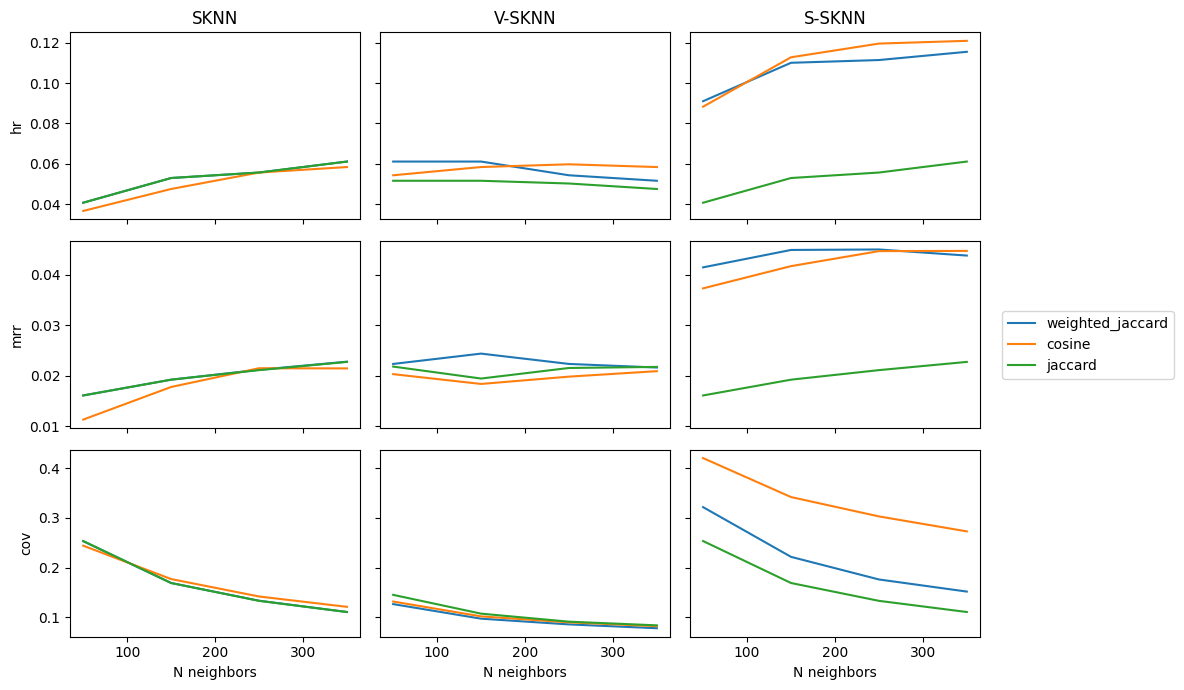

In [ ]:
histories = {
    'SKNN':history_sknn,
    'V-SKNN':history_v_sknn,
    'S-SKNN':history_s_sknn
}

plot_histories(histories)

# Extra. Scalable weighted jaccard index, MinHash.

All proofs and detailed derivations can be found in [Ioffe's original paper](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36928.pdf) and [Moulton's work](https://arxiv.org/pdf/1809.04052). There exists a python implementation available on [GitHub](https://github.com/ekzhu/datasketch). When feature vectors are very large and the Jaccard index needs to be computed frequently, using MinHash can significantly speed up the computations while maintaining comparable accuracy.

In [ ]:
!pip install datasketch

In [ ]:
from datasketch import WeightedMinHashGenerator
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
v1 = [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.0, 0.4]
v2 = [0.2, 0.4, 0.3, 0.8, 0.4, 0.7, 0.0, 0.9, 0.1, 0.0]

min_sum = np.sum(np.minimum(v1, v2))
max_sum = np.sum(np.maximum(v1, v2))
true_jaccard = float(min_sum) / float(max_sum)

wmg = WeightedMinHashGenerator(len(v1))
wm1 = wmg.minhash(v1)
wm2 = wmg.minhash(v2)
print("Estimated Jaccard is", wm1.jaccard(wm2))
print("True Jaccard is", true_jaccard)

In [ ]:
v1 = np.random.rand(1000000)
v2 = np.random.rand(1000000)
wmg = WeightedMinHashGenerator(len(v1))

wm1 = wmg.minhash(v1)
wm2 = wmg.minhash(v2)


In [ ]:
%%timeit -n 10 -r 10

min_sum = np.sum(np.minimum(v1, v2))
max_sum = np.sum(np.maximum(v1, v2))
float(min_sum) / float(max_sum)

In [ ]:
%%timeit -n 10 -r 10
wm1.jaccard(wm2)


In [ ]:
err = {}
n_samples = 100
sample_sizes = [10, 50, 100, 200, 500, 1000]
for sample_size in sample_sizes:
    if sample_size not in err:
        err[sample_size] = []
    for i in tqdm(range(n_samples)):
        v1 = np.random.rand(1000)
        v2 = np.random.rand(1000)
        wmg = WeightedMinHashGenerator(len(v1), seed=i, sample_size=sample_size)

        wm1 = wmg.minhash(v1)
        wm2 = wmg.minhash(v2)

        min_sum = np.sum(np.minimum(v1, v2))
        max_sum = np.sum(np.maximum(v1, v2))
        true = float(min_sum) / float(max_sum)
        err[sample_size].append((true - wm1.jaccard(wm2)) / true)

In [ ]:
for key in err:
    print(f'sample size: {key}, mean relative error: {np.mean(err[key]):.3f}')

In [ ]:
plot_err = {}
for key in err:
    plot_err[key] = np.std(err[key])
x, y = zip(*plot_err.items())
plt.plot(x, y)
plt.xlabel('Sample size')
plt.ylabel('Std of relative error')
plt.show()